# Decision Tree

Notebook to train a SVM model.

Evaluation metrics:
  
+ MSE
+ RMSE
+ MAE
+ MAPE

Steps:

1. 5-fold on training set
2. Find the best hyper parameters
3. 5-fold as the final training set, re-train with the best hyper parameters
4. Save model
5. Measure the performance on the test set

In [1]:
import numpy as np
import pandas as pd

In [2]:
raw_test_df = pd.read_csv('../../statistical-learning/processed_test.csv')
raw_train_df = pd.read_csv('../../statistical-learning/processed_training.csv')

## Preprocessing

In [3]:
# still need to one hot team1_name and team2_name

raw_train_df = pd.get_dummies(raw_train_df, columns=['team1_name', 'team2_name', 'season_type'])
raw_test_df = pd.get_dummies(raw_test_df, columns=['team1_name', 'team2_name', 'season_type'])

# drop columns: venue, start_hour
raw_train_df = raw_train_df.drop(columns=['venue', 'start_hour'], axis=1)
raw_test_df = raw_test_df.drop(columns=['venue', 'start_hour'], axis=1)

In [4]:
train_cols = raw_train_df.columns
raw_test_df = raw_test_df[train_cols].copy()

In [5]:
# see if there are any columns that are not in both dataframes
train_cols = set(raw_train_df.columns)
test_cols = set(raw_test_df.columns)

# make sure that the columns are the same
print(test_cols == train_cols)

True


In [6]:
raw_train_df.head(3)

,attendance,is_federal_holiday,on_grass,temperature,wind_speed,team1_pre_win,team1_pre_loss,team1_pre_win_pct,team1_streak,team2_pre_win,...,team2_name_SDP,team2_name_SEA,team2_name_SFG,team2_name_STL,team2_name_TBR,team2_name_TEX,team2_name_TOR,team2_name_WSN,season_type_post,season_type_regular
0,35055,0,1,-2.786672,-0.093090,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1
1,49043,0,1,0.705205,-0.093090,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1
2,43633,0,1,-0.521670,1.490839,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1


In [7]:
X, y = raw_train_df.drop(columns=['attendance'], axis=1), raw_train_df['attendance']

## Model Building

### Model Evaluation Function

In [8]:
# MSE, RMSE, MAE, MAPE

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def measure_model(y_true, y_pred, verbose=True, title=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    if verbose:
        print(f'''{"="*10} {title} {"="*10}
MSE: {mse:.2f}
RMSE: {rmse:.2f}
MAE: {mae:.2f}
MAPE: {mape:.2f}''')

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

In [30]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate, RandomizedSearchCV

### Simple Decision Tree Model

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Bagging Regressor
regr = DecisionTreeRegressor().fit(X_train, y_train)
y_pred_simple = regr.predict(X_valid)

_ = measure_model(y_valid, y_pred_simple, title='Simple Decision Tree Regressor')

========== Simple Decision Tree Regressor ==========
MSE: 36648946.93
RMSE: 6053.84
MAE: 4363.31
MAPE: 0.16


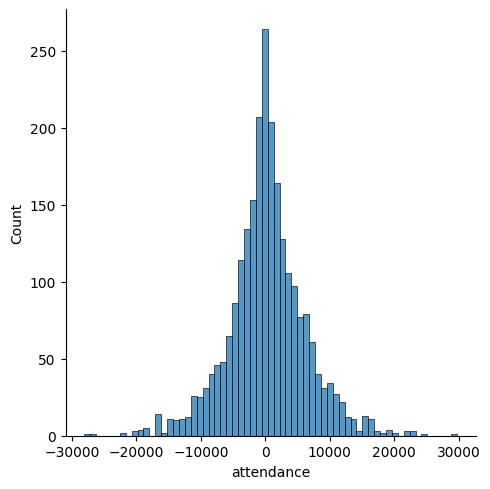

In [16]:
import seaborn as sns

sns.displot(y_valid - y_pred_simple)

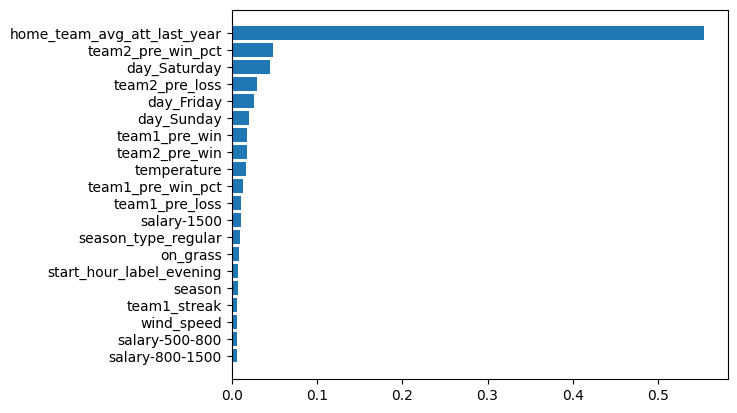

In [17]:
import matplotlib.pyplot as plt

feature_importances = regr.feature_importances_

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(X.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

### Hyperparameter Tuning

In [18]:
def find_best_index(eval_results: dict[str, np.array]) -> int:
    # returns a n-scorers x n-parameter-set dimensional array
    means_of_splits = np.array(
        [values for name, values in eval_results.items() if name.startswith('mean_test')]
    )
    # this is a n-parameter-set dimensional vector
    mean_of_all_scores = np.mean(means_of_splits, axis=0) 
    # get index of maximum value which corresponds to the best parameter set
    return np.argmax(mean_of_all_scores) 

In [54]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
param_grid = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["log2","sqrt",None],
           "max_leaf_nodes":[10,20,30,40,50,60,70,80,90]}


grid = RandomizedSearchCV(DecisionTreeRegressor(),param_grid, refit=find_best_index, verbose=2, scoring=scoring, cv=5, n_jobs=-1, n_iter=5000)

In [55]:
grid.fit(X, y)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=5000,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['log2', 'sqrt', None],
                                        'max_leaf_nodes': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   refit=<function find_best_index at 0x0000018E523BCAF0>,
                   scoring=['neg_mean_squared_error',
                            'neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'],
                   verbose=2)

### Use the best hyperparameters to train the model

In [56]:
grid.best_estimator_

DecisionTreeRegressor(max_depth=7, max_leaf_nodes=70, min_samples_leaf=10,
                      min_weight_fraction_leaf=0.1)

In [57]:
regr = DecisionTreeRegressor(**grid.best_params_).fit(X, y)

In [58]:
# save model in YYYYMMDD format
from datetime import datetime
import pickle

regr_filename = f'{datetime.today().strftime("%Y%m%d")}_dt_model.pkl'
pickle.dump(regr, open(regr_filename, 'wb'))

### Feature Importance

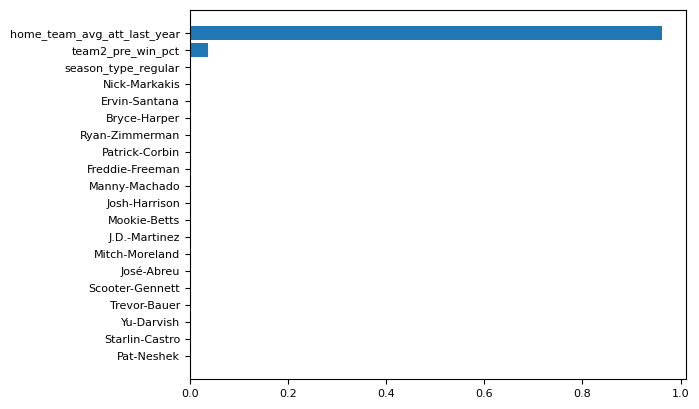

In [61]:
import matplotlib.pyplot as plt

feature_importances = regr.feature_importances_

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(X.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

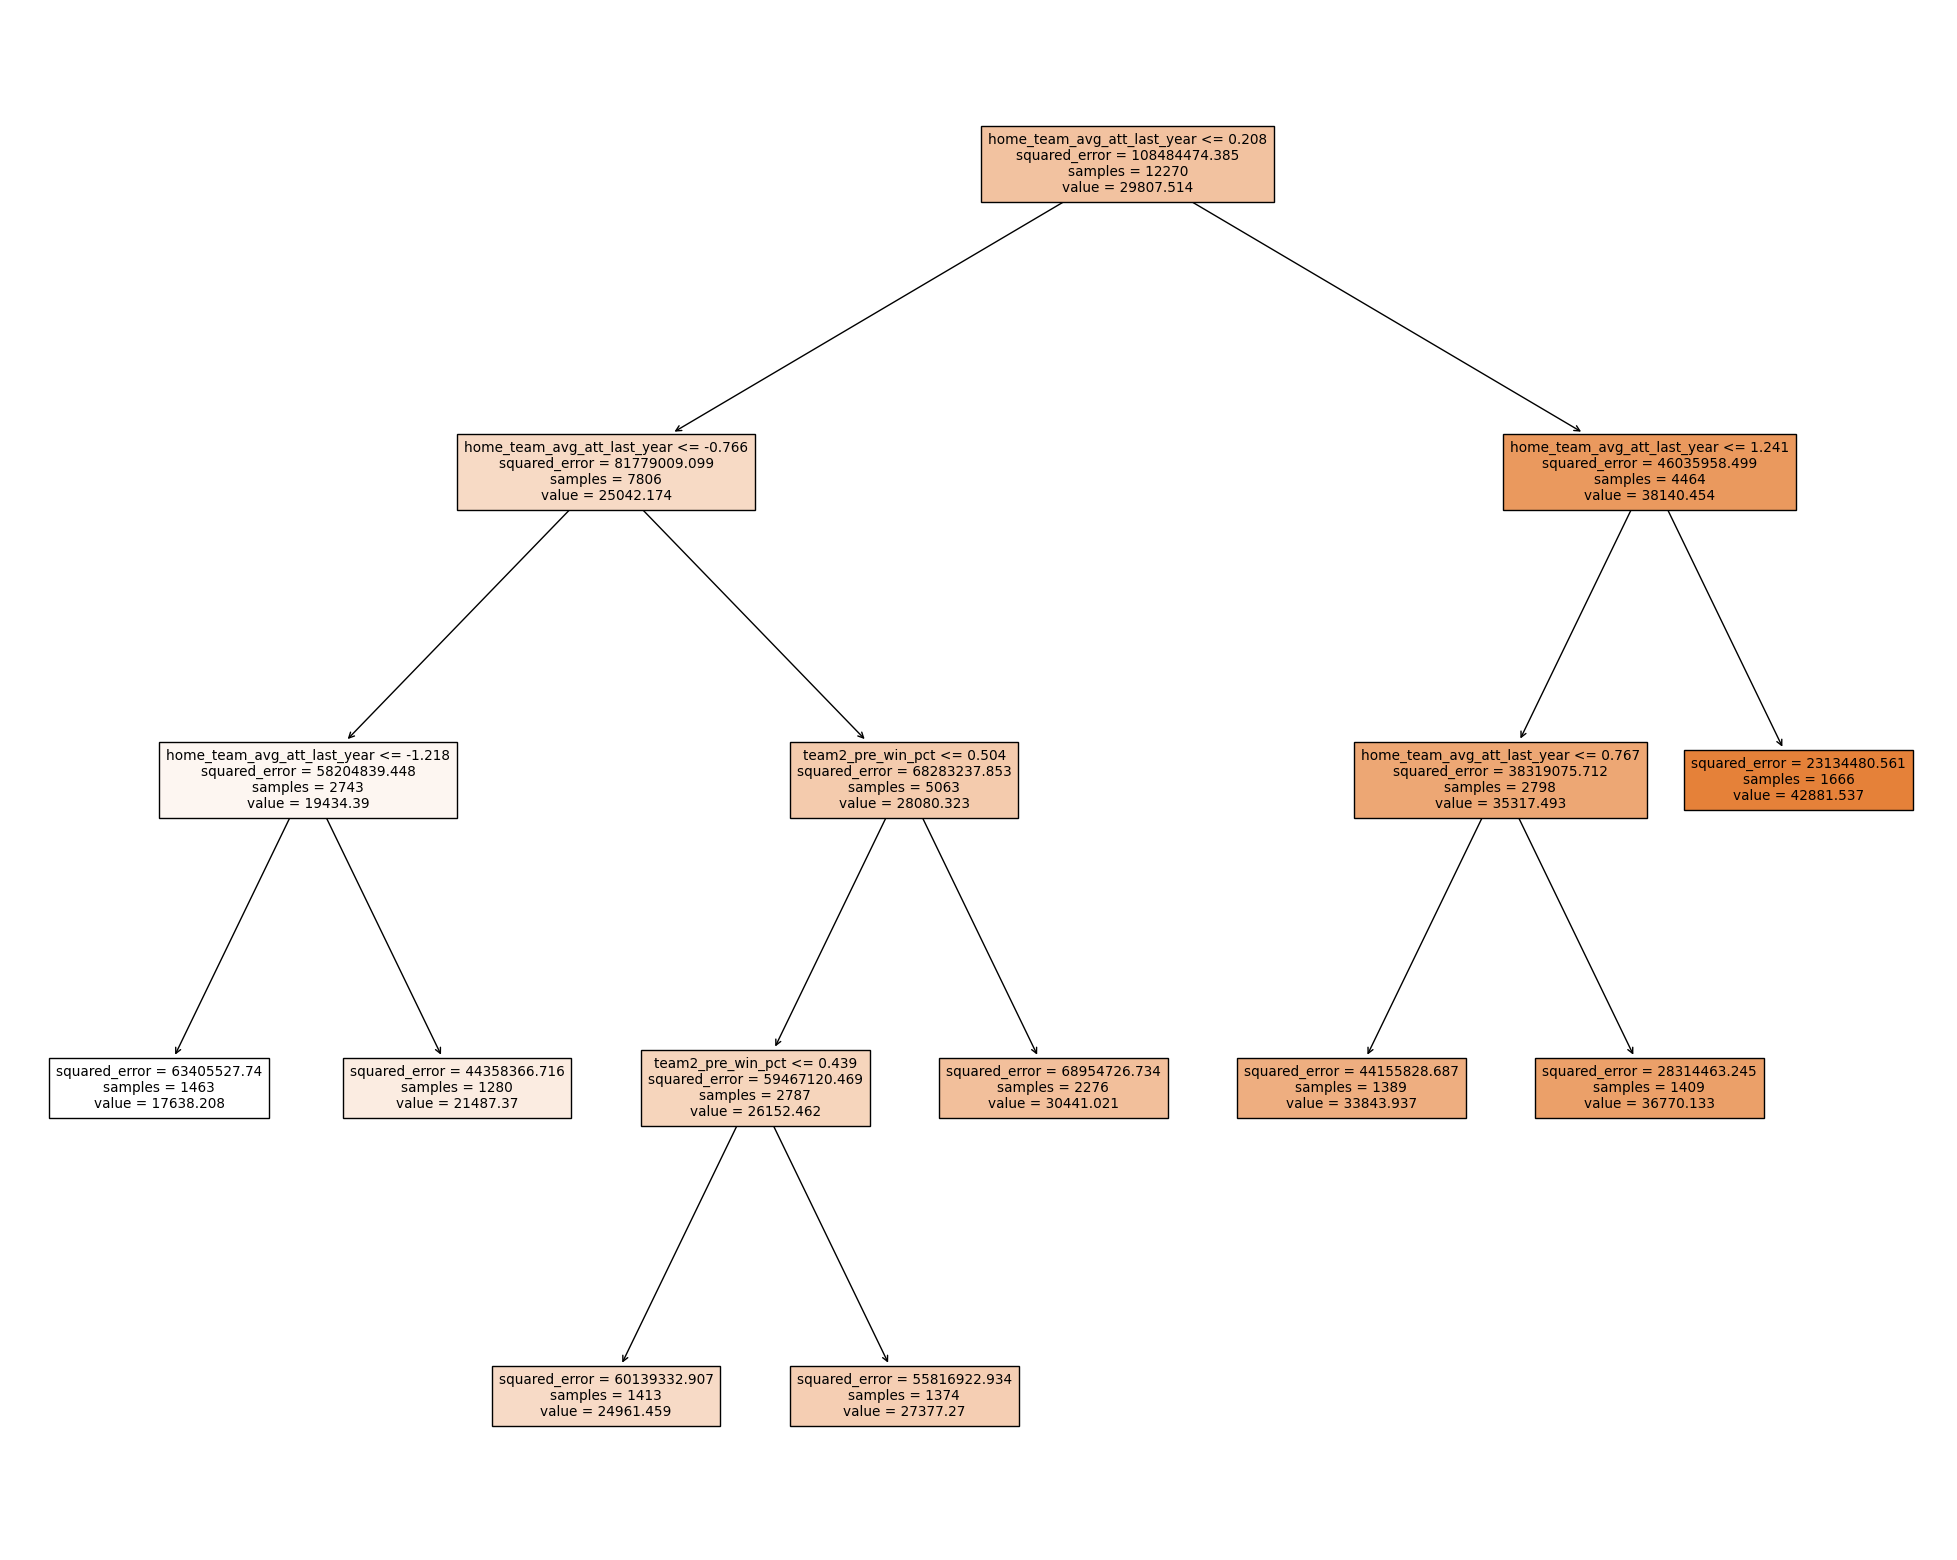

In [62]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr, feature_names=X.columns, filled=True)

## Model Evaluation

In [63]:
X_test, y_test = raw_test_df.drop(columns=['attendance'], axis=1), raw_test_df['attendance']

In [64]:
# read model
import pickle
regr = pickle.load(open('20221127_dt_model.pkl', 'rb'))
y_pred = regr.predict(X_test)

# performance
test_performance = measure_model(y_test, y_pred, title='Decision Tree')

========== Decision Tree ==========
MSE: 68199851.14
RMSE: 8258.32
MAE: 6695.69
MAPE: 0.37


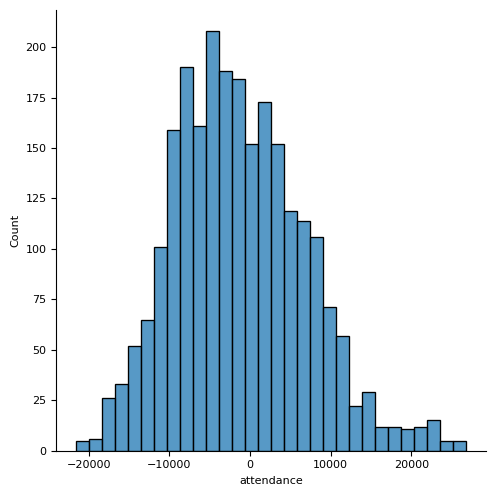

In [65]:
sns.displot(y_test - y_pred)

Note:

+ The model does a meh job with Decision Tree, but still can be improved through following ways (same as baggin):
    1. Player data may be too noisy, we can try to cut down player features with PCA or maybe just use salary ranks
    2. Venue capacities vary a lot, it'd be better if we can first group venues by capacity and then train models for each group
+ During hyper-parameter tuning session, 
    + Way too many parameters to tune
    + I have to use RandomizedSearch 
    + **Synthesis**: cutting down the parameters, and potentially the number of features could raise the bar
+ When comparing the decision tree model with the baseline model, we see that baseline (MA-5) did better, but it does way better than **average attendance of a stadium**. It is worse than "Bagging" and "SVM" models. 
+ `home team avg att last year` is still the most important feature; note that players are regarded as "important" here 

```
==================== MA(5) ====================
MSE:  32362577.913605437
RMSE:  5688.81164335799
MAE:  4399.588064076346
MAPE 0.21121206067333725
```

```
==================== Average Attendance Only ====================
MSE:  88887032.10373585
RMSE:  9427.991944403424
MAE:  7635.267692974473
MAPE 0.48553017390069386
```

```
========== Bagging Regressor ==========
MSE: 44278142.04
RMSE: 6654.18
MAE: 5128.62
MAPE: 0.26
```


```
========== SVM ==========
MSE: 43639164.99
RMSE: 6605.99
MAE: 5045.63
MAPE: 0.24
```

```
========== Decision Tree ==========
MSE: 68199851.14
RMSE: 8258.32
MAE: 6695.69
MAPE: 0.37
```